In [1]:
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import copy
import random

SEED = random.randint(1,100) 

Text(0, 0.5, 'X1')

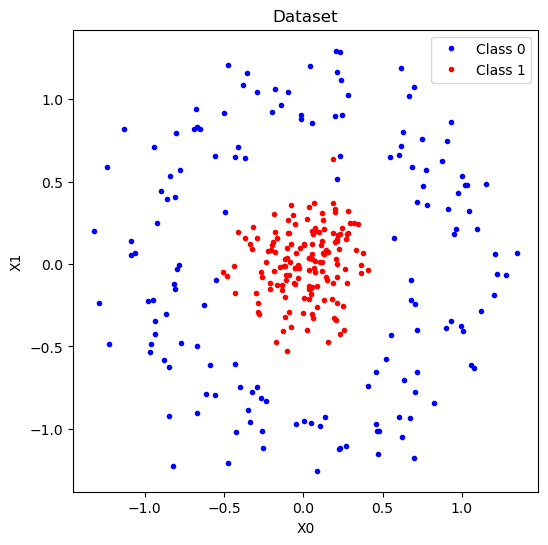

In [2]:
X,y = make_circles(n_samples=300, factor=0.1, noise=0.2,random_state=SEED)
n,s = X.shape
plt.figure(1,figsize=(6,6))
plt.plot(X[:,0][np.where(y==0)],X[:,1][np.where(y==0)],'.b', label='Class 0')
plt.plot(X[:,0][np.where(y==1)],X[:,1][np.where(y==1)],'.r', label='Class 1')
plt.title("Dataset")
plt.legend()
plt.xlabel("X0")
plt.ylabel("X1")

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

## Network Creation

In [ ]:
class InputUnit:
    def __init__(self,data):
        self.data = data        #one column of matrix X
        self.n = data.shape[0]  #dataset size
        self.k = 0              #layer number
        self.z = 0              #unit output

    def plug(self, unit):
        unit.plug(self)
        pass

feature_0 = InputUnit(X[:,0])
feature_1 = InputUnit(X[:,1])


In [ ]:
class Loss:
    #Constructor
    def __init__(self,y,k):
        self.preceding = [] #list of preceding neurons
        self.npr = 0        #length of list preceding
        self.y = y          #array of class labels of the training data
        self.k = k          #layer index

    def plug(self, unit):
        unit.plug(self,where='before')


In [ ]:
class NeuralUnit:
    #Constructor
    def __init__(self,k,u,seed = SEED):
        self.u = u          #unit number
        self.preceding = [] #list of preceding neurons
        self.npr = 0        #length of list preceding
        self.following = [] #list of following neurons
        self.nfo = 0        #length of list following
        self.k = k          #layer number
        self.w = 0          #unit weights
        self.b = 0          #unit intercept
        self.z = 0          #unit output
        self.rng = np.random.default_rng(seed=seed)

    def reset_params(self):
        self.w = self.rng.standard_normal(self.npr)
        self.b = self.rng.standard_normal()

    def plug(self,unit, where = 'after'):
        if unit.isintance(NeuralUnit):
            if where == 'following':
                self.preceding.append(unit)
                unit.following.append(self)
                self.npr += 1
                unit.nfo += 1
                print(f"{self} is after {unit}")
            elif where == 'preceding':
                self.following.append(unit)
                unit.preceding.append(self)
                self.nfo += 1
                unit.npr += 1
                print(f"{self} is before {unit}")
        elif unit.isinstance(InputUnit):
            if where == 'before':
                raise Exception("Not possible to add neurone befor the input layer")
            elif where == 'after':
                self.preceding.append(unit)
                self.npr += 1
        elif unit.isintance(Loss):
            if where == 'after':
                raise Exception("Not possible to add neurone after the Loss layer")
            elif where == 'before':
                self.following.append(unit)
                self.nfo += 1
                unit.preceding.append(self)
                unit.npr += 1
        pass

In [ ]:
class MLP:
#Constructor
    def __init__(self,X,y,archi):
        self.archi = archi
        self.X = X
        self.n = X.shape[0]
        self.y = y
        self.K = len(archi) #number of layers (including input layer but omitting loss layer)
        #creating network
        net = []
        #.... MISSING CODE ....
        self.net = net